# Analysing lines in XP spectra 
## Part II. Spectral line analyis following the path laid out by [Weiler+2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...671A..52W/abstract)


In [2]:
import numpy as np
import scipy
from astropy.table import Table
from matplotlib import pyplot as plt

import math_tools, spectrum_tools, line_analysis

## 1. Read some data

In [3]:
# Read configuration data
XPConstants = spectrum_tools.XPConstants(dr="dr3", calib="dr3+weiler2023")

# Read test XP data containing the 4 example Gaia DR3 stars discussed in the Weiler+2023 paper
t = Table.read("./data/xp_continuous_combined_weiler2023_examples.vot")
# Select the XP spectrum of one star
i       = 0
XP_spec = spectrum_tools.XP_Spectrum(t[0], rotate_basis=True)

## 2. Run getLinesInNDeriv to get the extrema

In [4]:
res0= line_analysis.getLinesInNDeriv(XP_spec.BP, XP_spec.BP_cov, N=0, instrument="bp", setup=XPConstants)
res2= line_analysis.getLinesInNDeriv(XP_spec.BP, XP_spec.BP_cov, N=2, instrument="bp", setup=None)

# Again, check with MW's results - first for the 0th derivative:
michael = [-4.267470, 60.397974,  2.138676, 56.683008,  3.821615, 55.978256, 45.447909,
           44.974094, 15.984259, 16.239673, 17.207323]
michael_signif = [0.06278744,    1, 0.9999616, 0.8931181, 0.9931747, 0.9492456,
                  0.5992521, 0.7470524, 0.9941945, 0.9406041, 0.9999987]
# And the 2nd:
michael2= [-5.4582873, 62.5725492, -0.6776125, 59.6638148,  1.8276495, 57.4319832,  
           3.8104770, 55.6731154,  5.2276424, 54.3845021, 6.1164165, 53.1986057,  
           7.1039342, 52.3441929, 8.3178609, 50.9159719,  9.3827927, 49.5564988,
           10.7392059, 48.5742640, 11.5980516, 13.2495340, 45.8421456, 14.9477839, 
           44.3890963, 16.4034377, 43.0071458, 17.3600270, 18.4072012, 19.4185784,
           20.4243364, 21.2573757, 38.1568490, 22.1493887, 37.1105429, 23.1162599, 
           35.9353616, 24.4664784, 34.4921121, 26.1276414, 33.2055566, 27.3159329, 
           31.7433472, 28.4638737, 29.9265393 ]

In [5]:
res0["estimLinePos"]

array([-4.26747004,  2.13867583,  3.82161536, 15.98425946, 16.23967286,
       17.20732257, 60.39797413, 44.97409384, 45.44790914, 56.68300847,
       55.9782563 ])

In [6]:
res0["estimSignif"]

array([0.06278744, 0.99996157, 0.99317471, 0.99419451, 0.94060414,
       0.99999867, 1.        , 0.74705236, 0.59925208, 0.89311807,
       0.94924556])

In [7]:
res2["estimLinePos"]

array([-5.45828735, -0.67761247,  1.82764946,  3.81047697,  5.22764236,
        6.11641647,  7.10393423,  8.31786091,  9.38279265, 10.73920589,
       11.59805164, 13.24953403, 14.94778387, 16.40343767, 17.36002698,
       18.40720122, 19.4185784 , 20.42433639, 21.25737569, 22.1493887 ,
       23.11625987, 24.46647845, 26.12764138, 27.31593285, 28.46387374,
       29.92653933, 31.74334725, 33.20555664, 34.49211206, 35.93536165,
       37.11054289, 38.15684899, 43.00714575, 44.38909627, 45.84214559,
       48.57426397, 49.55649885, 50.91597191, 52.34419287, 53.19860575,
       54.38450214, 55.67311536, 57.43198325, 59.66381477, 62.57254924])

(5.0, 55.0, -5.0, 1622.5967684278132)

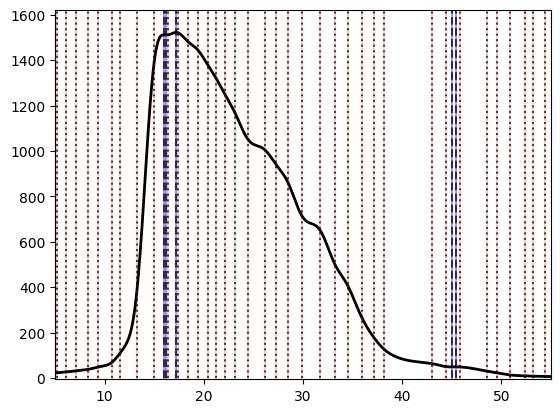

In [8]:
# Compare the found lines (extrema) to the ones obtained by Michael (black lines)
x           = np.linspace(-10,10, 1000)
l, internal = XP_spec.get_internal_spec(x, instrument="bp")
plt.plot(l, internal, c="k", lw=2)

plt.vlines(res0['estimLinePos'][res0['estimSignif']>1e-4], ymin=-100, ymax=np.max(internal)+100, alpha=0.4, color="blue")
plt.vlines(res2['estimLinePos'][res2['estimSignif']>0.1], ymin=-100, ymax=np.max(internal)+100, alpha=0.2, color="r")
plt.vlines(michael, ymin=0, ymax=np.max(internal)+100, alpha=0.7, color="k", ls="dashed")
plt.vlines(michael2, ymin=0, ymax=np.max(internal)+100, alpha=0.7, color="k", ls="dotted")

plt.axis([5, 55, -5, np.max(internal)+100])

## 3. Determine equivalent widths taking into account the LSF

In [10]:
import importlib
importlib.reload(spectrum_tools)

XPConstants = spectrum_tools.XPConstants(dr="dr3", calib="dr3+weiler2023")

In [12]:
u_arr   = np.linspace(5, 55, 15)
lsf_bp  = np.zeros(len(u_arr))
lsf_rp  = np.zeros(len(u_arr))

for ii in range(len(u_arr)):
    XPConstants = spectrum_tools.XPConstants(dr="dr3", calib="dr3+weiler2023")
    lsf_bp[ii]  = spectrum_tools.get_LSF_width(u_arr[ii], setup=XPConstants, 
                                D=1, order=0, instrument="bp")["D"]    
    lsf_rp[ii]  = spectrum_tools.get_LSF_width(u_arr[ii], setup=XPConstants, 
                                D=1, order=0, instrument="rp")["D"]

/home/friedel/Desktop/xp_spectral_lines/line_analysis.py:239: RuntimeWarning: divide by zero encountered in true_divide
  xinf = inf["thirdDerivativeAtRoots"] / inf["ErrorOnThirdDerivativeAtRoots"]
/home/friedel/Desktop/xp_spectral_lines/line_analysis.py:75: RuntimeWarning: divide by zero encountered in true_divide
  J = -np.diag(1/Hermite) @ math_tools.HermiteFunction(realRoots, n=n+1)
/home/friedel/Desktop/xp_spectral_lines/line_analysis.py:75: RuntimeWarning: invalid value encountered in matmul
  J = -np.diag(1/Hermite) @ math_tools.HermiteFunction(realRoots, n=n+1)
/home/friedel/Desktop/xp_spectral_lines/line_analysis.py:234: RuntimeWarning: invalid value encountered in true_divide
  x = e["secondDerivativeAtRoots"] / e["ErrorOnSecondDerivativeAtRoots"]


ValueError: zero-size array to reduction operation maximum which has no identity

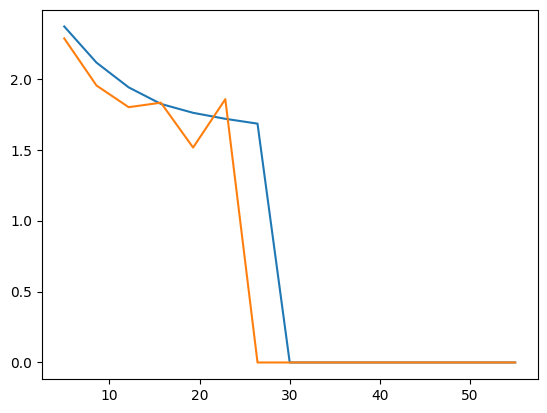

In [131]:
plt.plot(u_arr, lsf_bp)
plt.plot(u_arr, lsf_rp)


In [123]:
weiler2023_tools.HermiteFunction(np.array([1.]), 12).ravel()

array([ 0.45558067,  0.64428837,  0.32214418, -0.26302962, -0.46497508,
       -0.05881521,  0.39050525,  0.26318614, -0.23369114, -0.35829734,
        0.06146344,  0.36783121])

In [ ]:
plt.matshow(XPConstants.LSFBP) 